In [1]:
# imports

import numpy as np
from numpy import mean
from numpy import std
from numpy import absolute
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
import datetime



In [2]:
df = pd.read_csv('Train.csv')

# https://www.kaggle.com/datasets/abhishekgautam12/jpmc-quant?select=Train.csv

In [3]:
# The idea of this project is to use balance sheet data to predict a stock's price

In [4]:
df.head()

,Date,Stock,liabilities,equity,total_assets,current_assets,current_liabilities,total_revenue,net_income,dividend,shares_outstanding,price
0,2006-07-31,Stock 1,625.898686,925.086518,1550.985204,675.789905,555.931329,548.488451,251.282553,68.184030,1040831,100.000000
1,2006-08-31,Stock 1,407.387467,903.249093,1310.636561,1023.110983,1295.186240,513.446432,207.576940,42.232672,1046649,101.924169
2,2006-09-29,Stock 1,464.069891,602.668832,1066.738722,709.711673,598.719338,503.519871,133.719700,28.835722,1094158,103.166191
3,2006-10-31,Stock 1,855.854937,391.375369,1247.230306,649.979564,733.594339,596.006397,-76.881818,0.000000,1018574,104.478956
4,2006-11-30,Stock 1,453.954969,956.490566,1410.445534,1115.594551,1152.274711,965.939247,-309.204301,0.000000,1036293,104.160907


In [5]:
dfstock_1 = df[df['Stock'] == 'Stock 1']

In [6]:
dfstock_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 150 non-null    object 
 1   Stock                150 non-null    object 
 2   liabilities          150 non-null    float64
 3   equity               150 non-null    float64
 4   total_assets         150 non-null    float64
 5   current_assets       150 non-null    float64
 6   current_liabilities  150 non-null    float64
 7   total_revenue        150 non-null    float64
 8   net_income           150 non-null    float64
 9   dividend             150 non-null    float64
 10  shares_outstanding   150 non-null    int64  
 11  price                150 non-null    float64
dtypes: float64(9), int64(1), object(2)
memory usage: 15.2+ KB


In [7]:
dfstock_1.describe()

,liabilities,equity,total_assets,current_assets,current_liabilities,total_revenue,net_income,dividend,shares_outstanding,price
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,1.500000e+02,150.000000
mean,560.784820,530.635341,1091.420161,601.917385,621.355567,551.068991,21.842957,18.436919,1.050248e+06,118.128898
std,259.044511,278.940853,359.941061,255.367999,280.428285,280.946513,164.178374,27.171840,2.841855e+04,7.591741
min,100.068495,102.039178,285.656697,96.206793,97.605022,103.233357,-418.378269,0.000000,1.000753e+06,100.000000
25%,339.015652,269.481997,880.243062,418.278973,415.979788,283.505359,-70.640190,0.000000,1.025959e+06,113.351152
50%,587.047512,525.510461,1103.029930,576.163671,576.201465,550.324657,9.512224,2.356472,1.054365e+06,121.553277
75%,774.912477,776.957911,1331.325492,738.397070,750.821758,803.608259,125.345491,32.528806,1.071502e+06,124.406799
max,996.050155,989.364516,1931.478841,1335.469155,1595.754465,997.375694,435.857944,130.302688,1.099820e+06,127.651581


In [8]:
dfstock_1.tail()

,Date,Stock,liabilities,equity,total_assets,current_assets,current_liabilities,total_revenue,net_income,dividend,shares_outstanding,price
145,2018-08-31,Stock 1,942.616474,609.920789,1552.537263,661.976873,715.889802,936.585763,88.769479,19.084403,1022653,120.895608
146,2018-09-28,Stock 1,418.596827,584.891097,1003.487923,774.901898,859.111171,791.455748,139.537471,32.383487,1012494,120.817216
147,2018-10-31,Stock 1,238.005662,788.400811,1026.406473,583.243894,719.977839,533.621702,-257.296635,0.000000,1088180,121.541253
148,2018-11-30,Stock 1,806.255849,637.488221,1443.744070,636.300679,561.640812,680.740216,-72.796162,0.000000,1046014,120.380297
149,2018-12-31,Stock 1,737.221144,718.365340,1455.586484,619.734902,690.981133,199.451368,-12.169262,0.000000,1074004,119.687371


In [9]:
# to predict price we need to do two things for time series modeling. The first is to set row 0 price = row 1 price for prediction sake, then to drop the last row since we won't have the data necessary to predict forward. 

dfstock_1.price.shift(-1) # shift the price data

0      101.924169
1      103.166191
2      104.478956
3      104.160907
4      103.133923
          ...    
145    120.817216
146    121.541253
147    120.380297
148    119.687371
149           NaN
Name: price, Length: 150, dtype: float64

In [10]:
dfstock_1.drop(dfstock_1.tail(1).index,inplace=True) # drop last n rows

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
dfstock_1.info() # 149 and shifted

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 148
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 149 non-null    object 
 1   Stock                149 non-null    object 
 2   liabilities          149 non-null    float64
 3   equity               149 non-null    float64
 4   total_assets         149 non-null    float64
 5   current_assets       149 non-null    float64
 6   current_liabilities  149 non-null    float64
 7   total_revenue        149 non-null    float64
 8   net_income           149 non-null    float64
 9   dividend             149 non-null    float64
 10  shares_outstanding   149 non-null    int64  
 11  price                149 non-null    float64
dtypes: float64(9), int64(1), object(2)
memory usage: 15.1+ KB


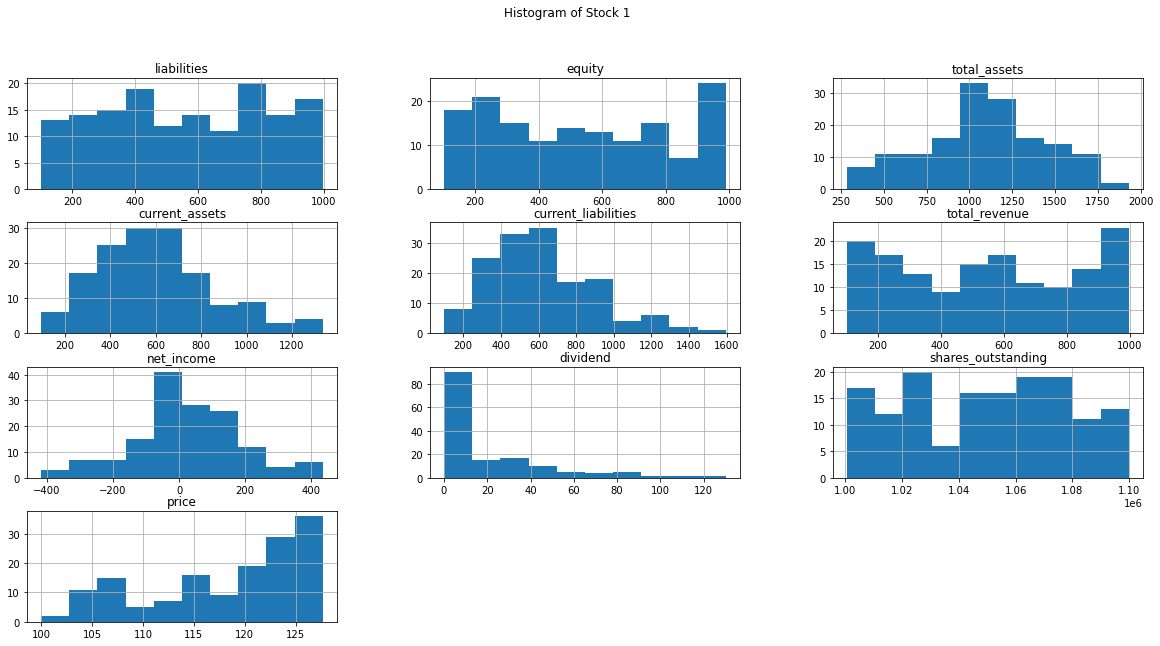

In [12]:
# let's visualize and do EDA

dfstock_1.hist(figsize=(20,10))
plt.suptitle('Histogram of Stock 1')
plt.show()

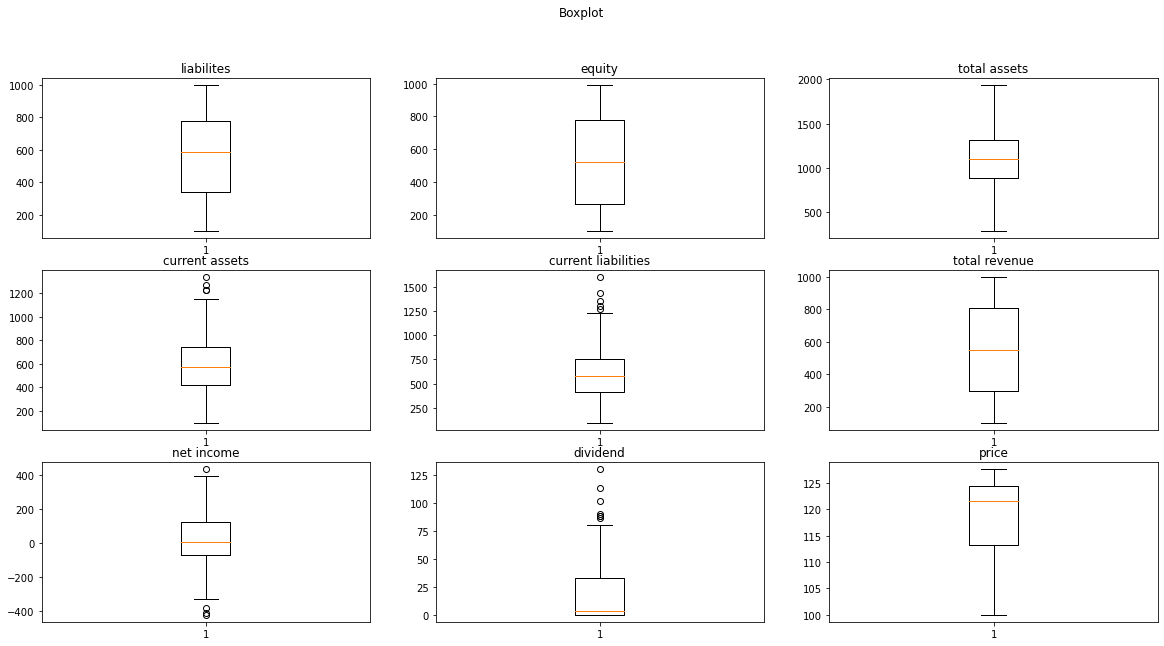

In [13]:
# looking for outliers

plt.figure(figsize=(20,10))
plt.suptitle('Boxplot')

plt.subplot(3,3,1)
plt.title('liabilites')
plt.boxplot(dfstock_1['liabilities'])

plt.subplot(3,3,2)
plt.title('equity')
plt.boxplot(dfstock_1['equity'])

plt.subplot(3,3,3)
plt.title('total assets')
plt.boxplot(dfstock_1['total_assets'])

plt.subplot(3,3,4)
plt.title('current assets')
plt.boxplot(dfstock_1['current_assets'])

plt.subplot(3,3,5)
plt.title('current liabilities')
plt.boxplot(dfstock_1['current_liabilities'])

plt.subplot(3,3,6)
plt.title('total revenue')
plt.boxplot(dfstock_1['total_revenue'])

plt.subplot(3,3,7)
plt.title('net income')
plt.boxplot(dfstock_1['net_income'])

plt.subplot(3,3,8)
plt.title('dividend')
plt.boxplot(dfstock_1['dividend'])

plt.subplot(3,3,9)
plt.title('price')
plt.boxplot(dfstock_1['price'])

plt.show()

In [14]:
# going to winsorize to get rid of outliers

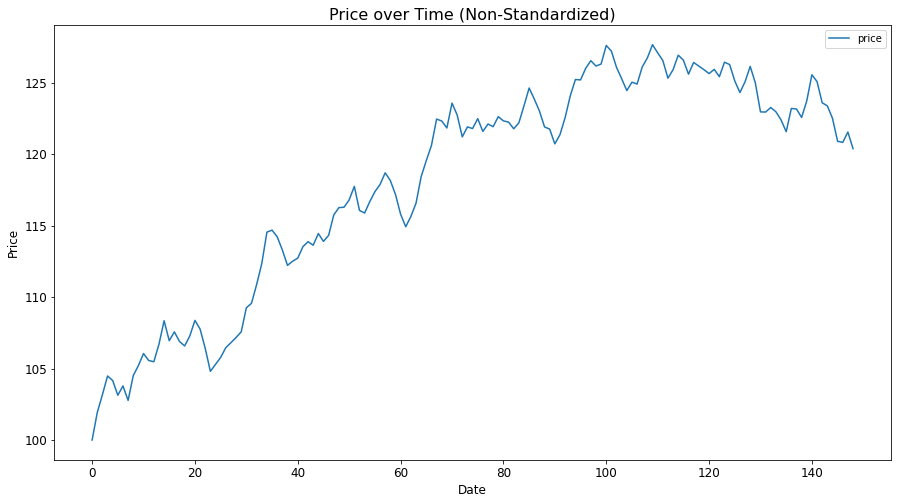

In [15]:
cdfstock_1 = dfstock_1 # clean df stock of 1

# let's visualize price over time

cdfstock_1.plot(y='price', subplots=True, figsize=(15, 8), fontsize=12)
plt.title('Price over Time (Non-Standardized)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [16]:
cdfstock_1['current_assets'] = winsorize(dfstock_1['current_assets'], (.05, 0.05))
cdfstock_1['current_liabilities'] = winsorize(dfstock_1['current_liabilities'], (.05, 0.05))
cdfstock_1['net_income'] = winsorize(dfstock_1['net_income'], (.05, 0.05))
cdfstock_1['dividend'] = winsorize(dfstock_1['dividend'], (.0, 0.1))
cdfstock_1['price'] = winsorize(dfstock_1['price'], (.05, 0.05))

C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/460861446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfstock_1['current_assets'] = winsorize(dfstock_1['current_assets'], (.05, 0.05))
C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/460861446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfstock_1['current_liabilities'] = winsorize(dfstock_1['current_liabilities'], (.05, 0.05))
C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/460861446.py:3: SettingWithCopyWarning: 
A value is tryi

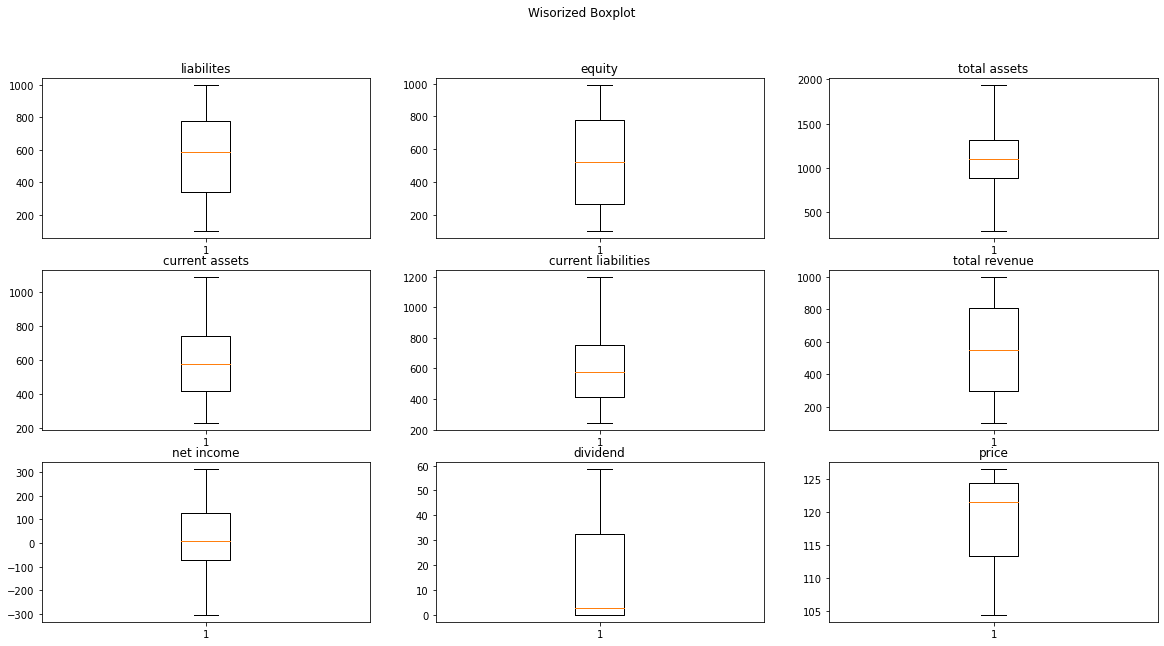

In [17]:
# plotting winsorized data

plt.figure(figsize=(20,10))
plt.suptitle('Wisorized Boxplot')

plt.subplot(3,3,1)
plt.title('liabilites')
plt.boxplot(cdfstock_1['liabilities'])

plt.subplot(3,3,2)
plt.title('equity')
plt.boxplot(cdfstock_1['equity'])

plt.subplot(3,3,3)
plt.title('total assets')
plt.boxplot(cdfstock_1['total_assets'])

plt.subplot(3,3,4)
plt.title('current assets')
plt.boxplot(cdfstock_1['current_assets'])

plt.subplot(3,3,5)
plt.title('current liabilities')
plt.boxplot(cdfstock_1['current_liabilities'])

plt.subplot(3,3,6)
plt.title('total revenue')
plt.boxplot(cdfstock_1['total_revenue'])

plt.subplot(3,3,7)
plt.title('net income')
plt.boxplot(cdfstock_1['net_income'])

plt.subplot(3,3,8)
plt.title('dividend')
plt.boxplot(cdfstock_1['dividend'])

plt.subplot(3,3,9)
plt.title('price')
plt.boxplot(cdfstock_1['price'])

plt.show()

# multivariate analysis


In [19]:
corrmat = cdfstock_1.corr()['price']


In [20]:
print(corrmat)

liabilities           -0.031956
equity                 0.056920
total_assets           0.021154
current_assets        -0.047518
current_liabilities   -0.054563
total_revenue         -0.027295
net_income            -0.199960
dividend              -0.173020
shares_outstanding    -0.008032
price                  1.000000
Name: price, dtype: float64


# I am seeing little correlation with any variable and price... current liabilities and current assets / net income and dividend appear to be highly correlated

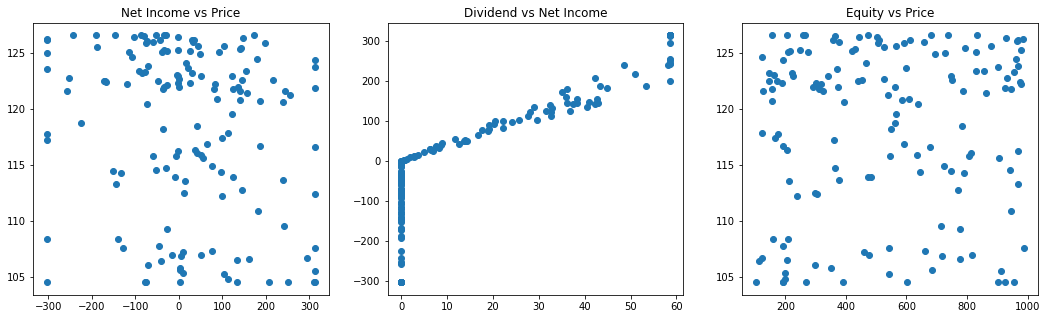

In [22]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(cdfstock_1['net_income'], cdfstock_1['price'])
plt.title('Net Income vs Price')

plt.subplot(1,3,2)
plt.scatter(cdfstock_1['dividend'], cdfstock_1['net_income'])
plt.title('Dividend vs Net Income')

plt.subplot(1,3,3)
plt.scatter(cdfstock_1['equity'], cdfstock_1['price'])
plt.title('Equity vs Price')


plt.show()

In [23]:
# I am going to take the difference of current assets and current liabilities to make a new feature 'working capital', so that we have one less feature in our dataset.

In [24]:
cdfstock_1['working_capital'] = cdfstock_1['current_assets'] - cdfstock_1['current_liabilities']

C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/2368073926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfstock_1['working_capital'] = cdfstock_1['current_assets'] - cdfstock_1['current_liabilities']


In [25]:
cdfstock_1.head()

,Date,Stock,liabilities,equity,total_assets,current_assets,current_liabilities,total_revenue,net_income,dividend,shares_outstanding,price,working_capital
0,2006-07-31,Stock 1,625.898686,925.086518,1550.985204,675.789905,555.931329,548.488451,251.282553,58.541276,1040831,104.478956,119.858577
1,2006-08-31,Stock 1,407.387467,903.249093,1310.636561,1023.110983,1195.810967,513.446432,207.576940,42.232672,1046649,104.478956,-172.699984
2,2006-09-29,Stock 1,464.069891,602.668832,1066.738722,709.711673,598.719338,503.519871,133.719700,28.835722,1094158,104.478956,110.992335
3,2006-10-31,Stock 1,855.854937,391.375369,1247.230306,649.979564,733.594339,596.006397,-76.881818,0.000000,1018574,104.478956,-83.614775
4,2006-11-30,Stock 1,453.954969,956.490566,1410.445534,1083.426267,1152.274711,965.939247,-303.231573,0.000000,1036293,104.478956,-68.848444


In [26]:
# OLS attempt num. 1

# `Y` is the target variable
Y = cdfstock_1['price']
# `X` is the feature set which includes the financial ratios that we created from the data
X = cdfstock_1.drop(['price','Stock','Date','current_assets','current_liabilities'], 1)

lrm = linear_model.LinearRegression()

# Fit method estimates the coefficients using OLS
lrm.fit(X, Y)

C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/3920995155.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = cdfstock_1.drop(['price','Stock','Date','current_assets','current_liabilities'], 1)


LinearRegression()

In [27]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.027
Date:                Fri, 07 Jun 2024   Prob (F-statistic):              0.415
Time:                        13:56:04   Log-Likelihood:                -505.79
No. Observations:                 149   AIC:                             1028.
Df Residuals:                     141   BIC:                             1052.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                133.6949     23.348      5.726      0.000      87.537     179.853
liabilities           -0.0014      0.002     -0.814      0.417      -0.005       0.002
equity                 0.0015      0.002      0.932      0.353      -0.002       0.005
total_assets           0.0001      0.001      0.129      0.897      -0.002       0.002
total_revenue        6.04e-05      0.003      0.023      0.982      -0.005       0.005
net_income            -0.0094      0.009     -1.016      0.311      -0.028       0.009
dividend              -0.0076      0.072     -0.105      0.916      -0.151       0.136
shares_outstanding -1.465e-05   2.22e-05     -0.661      0.510   -5.85e-05    2.92e-05
working_capital        0.0021      0.006      0.332      0.741      -0.011       0.015
==============================================================================
Omnibus:                       26.191   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.320
Skew:                          -0.635   Prob(JB):                     0.000471
Kurtosis:                       2.077   Cond. No.                     6.42e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.99e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [28]:
# svm

svr = SVR()
X = cdfstock_1.drop(['price','Stock','Date','current_assets','current_liabilities'], 1).sample(frac=0.3, replace=True)
Y = cdfstock_1.price.sample(frac=0.3, replace=True)
svr.fit(X,Y)


C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/1020041314.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = cdfstock_1.drop(['price','Stock','Date','current_assets','current_liabilities'], 1).sample(frac=0.3, replace=True)


SVR()

In [29]:
svr.score(X, Y)


-0.15137375204709924

In [30]:
# both those models prove to not work effectively at this stage. I am going to normalize and transform the data to see what kind of impact that will have. 

In [31]:
cdfstock_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 148
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 149 non-null    object 
 1   Stock                149 non-null    object 
 2   liabilities          149 non-null    float64
 3   equity               149 non-null    float64
 4   total_assets         149 non-null    float64
 5   current_assets       149 non-null    float64
 6   current_liabilities  149 non-null    float64
 7   total_revenue        149 non-null    float64
 8   net_income           149 non-null    float64
 9   dividend             149 non-null    float64
 10  shares_outstanding   149 non-null    int64  
 11  price                149 non-null    float64
 12  working_capital      149 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 16.3+ KB


In [32]:
# normalizing

cdfstock_1["liabilites"] = normalize(np.array(cdfstock_1["liabilities"]).reshape(1,-1)).reshape(-1,1)
cdfstock_1["equity"] = normalize(np.array(cdfstock_1["equity"]).reshape(1,-1)).reshape(-1,1)
cdfstock_1["total_assets"] = normalize(np.array(cdfstock_1["total_assets"]).reshape(1,-1)).reshape(-1,1)
cdfstock_1["current_assets"] = normalize(np.array(cdfstock_1["current_assets"]).reshape(1,-1)).reshape(-1,1)
cdfstock_1["current_liabilities"] = normalize(np.array(cdfstock_1["current_liabilities"]).reshape(1,-1)).reshape(-1,1)
cdfstock_1["total_revenue"] = normalize(np.array(cdfstock_1["total_revenue"]).reshape(1,-1)).reshape(-1,1)
cdfstock_1["net_income"] = normalize(np.array(cdfstock_1["net_income"]).reshape(1,-1)).reshape(-1,1)
cdfstock_1["dividend"] = normalize(np.array(cdfstock_1["dividend"]).reshape(1,-1)).reshape(-1,1)
cdfstock_1["shares_outstanding"] = normalize(np.array(cdfstock_1["shares_outstanding"]).reshape(1,-1)).reshape(-1,1)
cdfstock_1["price"] = normalize(np.array(cdfstock_1["price"]).reshape(1,-1)).reshape(-1,1)
cdfstock_1["working_capital"] = normalize(np.array(cdfstock_1["working_capital"]).reshape(1,-1)).reshape(-1,1)

C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/3782673076.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfstock_1["liabilites"] = normalize(np.array(cdfstock_1["liabilities"]).reshape(1,-1)).reshape(-1,1)
C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/3782673076.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfstock_1["equity"] = normalize(np.array(cdfstock_1["equity"]).reshape(1,-1)).reshape(-1,1)
C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/3782673076.py:5: SettingWithCopyWar

In [33]:
# standardizing

cdfstock_1["liabilities"] = scale(cdfstock_1["liabilities"])
cdfstock_1["equity"] = scale(cdfstock_1["equity"])
cdfstock_1["total_assets"] = scale(cdfstock_1["total_assets"])
cdfstock_1["current_assets"] = scale(cdfstock_1["current_assets"])
cdfstock_1["current_liabilities"] = scale(cdfstock_1["current_liabilities"])
cdfstock_1["total_revenue"] = scale(cdfstock_1["total_revenue"])
cdfstock_1["net_income"] = scale(cdfstock_1["net_income"])
cdfstock_1["dividend"] = scale(cdfstock_1["dividend"])
cdfstock_1["shares_outstanding"] = scale(cdfstock_1["shares_outstanding"])
cdfstock_1["price"] = scale(cdfstock_1["price"])
cdfstock_1["working_capital"] = scale(cdfstock_1["working_capital"])

C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/2693500894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfstock_1["liabilities"] = scale(cdfstock_1["liabilities"])
C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/2693500894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfstock_1["equity"] = scale(cdfstock_1["equity"])
C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/2693500894.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

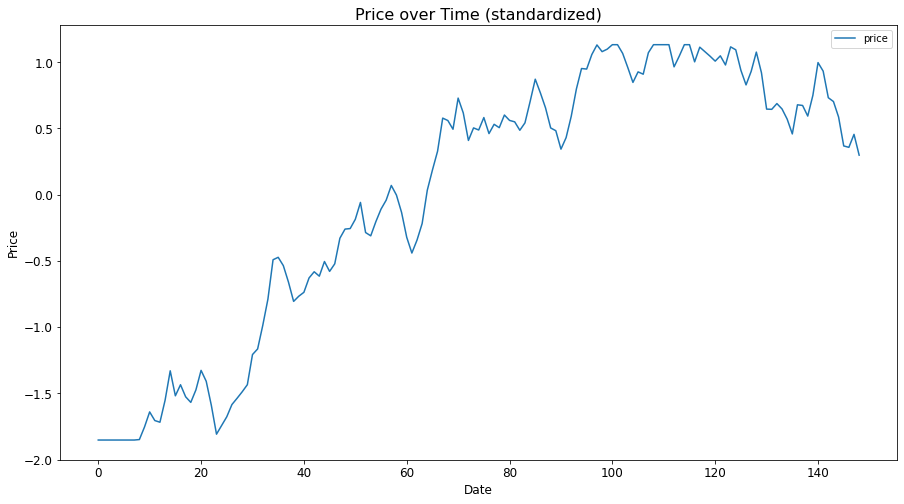

In [34]:
# prices over time standardized / normalized

cdfstock_1.plot(y='price', subplots=True, figsize=(15, 8), fontsize=12)
plt.title('Price over Time (standardized)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [35]:
# OLS attempt num. 2

# `Y` is the target variable
Y = cdfstock_1['price']
# `X` is the feature set which includes the financial ratios that we created from the data
X = cdfstock_1.drop(['price','Stock','Date','current_assets','current_liabilities'], 1)

lrm = linear_model.LinearRegression()

# Fit method estimates the coefficients using OLS
lrm.fit(X, Y)

C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/5604572.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = cdfstock_1.drop(['price','Stock','Date','current_assets','current_liabilities'], 1)


LinearRegression()

In [36]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

# little to no impact, going to attempt SVM next

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.027
Date:                Fri, 07 Jun 2024   Prob (F-statistic):              0.415
Time:                        13:56:04   Log-Likelihood:                -207.72
No. Observations:                 149   AIC:                             431.4
Df Residuals:                     141   BIC:                             455.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0001      0.082      0.002      0.999      -0.161       0.162
liabilities           -0.0499      0.066     -0.759      0.449      -0.180       0.080
equity                 0.0573      0.064      0.900      0.370      -0.068       0.183
total_assets           0.0085      0.044      0.194      0.847      -0.078       0.095
total_revenue          0.0023      0.101      0.023      0.982      -0.197       0.202
net_income            -0.1929      0.190     -1.016      0.311      -0.568       0.183
dividend              -0.0214      0.203     -0.105      0.916      -0.423       0.381
shares_outstanding    -0.0562      0.085     -0.661      0.510      -0.224       0.112
working_capital        0.0273      0.082      0.332      0.741      -0.135       0.190
liabilites            -0.0017      0.006     -0.263      0.793      -0.014       0.011
==============================================================================
Omnibus:                       26.191   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.320
Skew:                          -0.635   Prob(JB):                     0.000471
Kurtosis:                       2.077   Cond. No.                     1.19e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.19e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [37]:
# SVM 2


svr = SVR()
X = cdfstock_1.drop(['price','Stock','Date','current_assets','current_liabilities'], 1).sample(frac=0.3, replace=True)
Y = cdfstock_1.price.sample(frac=0.3, replace=True)
svr.fit(X,Y)

C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/585127230.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = cdfstock_1.drop(['price','Stock','Date','current_assets','current_liabilities'], 1).sample(frac=0.3, replace=True)


SVR()

In [38]:
svr.score(X, Y)

# large improvement in model performance after normalizing and standardizing 

0.18134338372874959

In [39]:
# hyperparameter tuning for time series forecasting with support vector regressor


svr = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
X = cdfstock_1.drop(['price','Stock','Date','current_assets','current_liabilities'], 1).sample(frac=0.3, replace=True)
Y = cdfstock_1.price.sample(frac=0.3, replace=True)
svr.fit(X,Y)

C:\Users\500225~2\AppData\Local\Temp/ipykernel_1396/2488529139.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = cdfstock_1.drop(['price','Stock','Date','current_assets','current_liabilities'], 1).sample(frac=0.3, replace=True)


SVR(C=10, epsilon=0.05, gamma=0.5)

In [40]:
svr.score(X, Y)

# significantly higher score due to tuning. 

0.9150340195885984

In [41]:
# SVM outperforms OLS when it comes to predicting stock price with the balance sheet data. 